# import file


In [1]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

from transformers.utils import logging
logging.set_verbosity_error()

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse


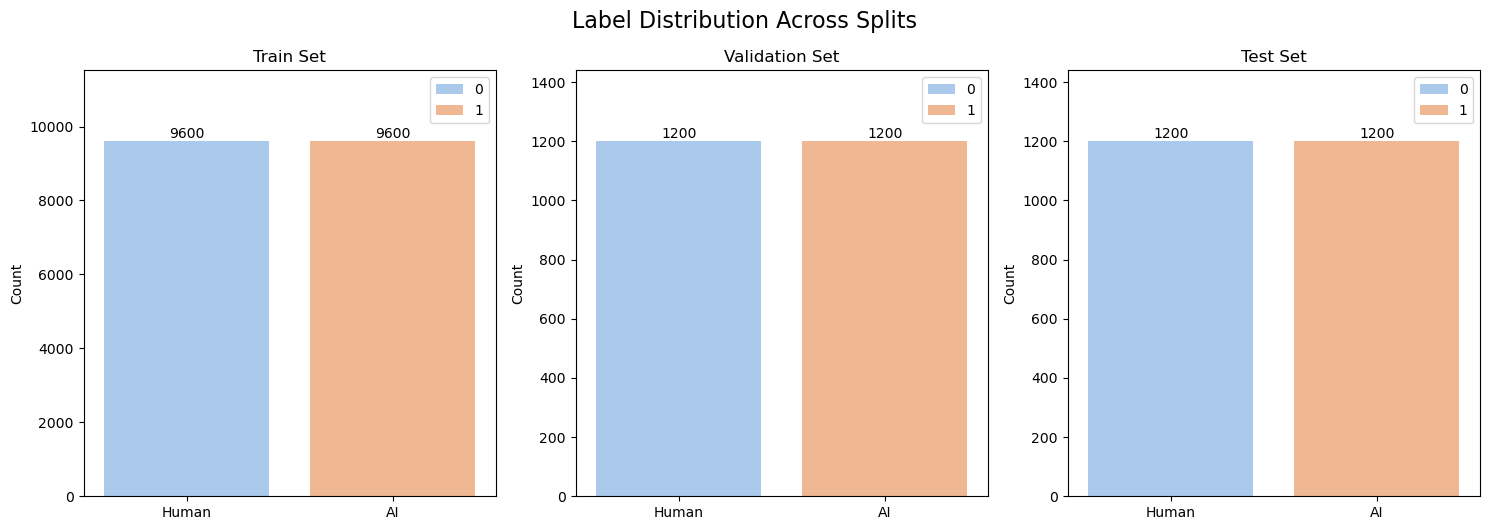

In [2]:
# 1. Load dataset
df = pd.read_csv("../Final_Dataset_Fixed.csv")

# Encode labels: human=0, ai=1
df['label'] = df['label'].map({'human': 0, 'ai': 1})

# Split into train, validation, test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(),
    test_size=0.2, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)

# --- Plot class distributions ---
splits = {
    "Train": train_labels,
    "Validation": val_labels,
    "Test": test_labels,
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (split_name, split_labels) in enumerate(splits.items()):
    counts = pd.Series(split_labels).value_counts().sort_index()
    class_names = ['Human', 'AI']
    sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel", hue=[0, 1])
    axs[i].set_title(f"{split_name} Set")
    axs[i].set_ylabel("Count")
    axs[i].set_ylim(0, max(counts.values) * 1.2)
    for j, count in enumerate(counts.values):
        axs[i].text(j, count + 2, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle("Label Distribution Across Splits", fontsize=16, y=1.05)
plt.savefig("Label Distribution.png")
plt.show()

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Use XLM-RoBERTa-base for classification
model_name = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Dataset class
class BengaliDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

train_dataset = BengaliDataset(train_encodings, train_labels)
val_dataset = BengaliDataset(val_encodings, val_labels)
test_dataset = BengaliDataset(test_encodings, test_labels)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

c:\Users\Jim\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Jim\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

## Training

In [6]:
# ... (Previous imports and code remain unchanged until the callback definition)

from transformers import TrainingArguments, Trainer, TrainerCallback, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

# --- Metrics function ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (tuple, list)):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# --- Custom callback to evaluate on train set after each validation ---
class TrainEvalCallback(TrainerCallback):
    def __init__(self):
        super().__init__()

    def on_evaluate(self, args, state, control, **kwargs):
        # Access the trainer via kwargs
        trainer = kwargs.get("trainer")
        if trainer is not None and state.is_local_process_zero:
            train_metrics = trainer.evaluate(
                eval_dataset=trainer.train_dataset,
                metric_key_prefix="train"
            )
            trainer.log(train_metrics)

# --- Training args ---
output_dir = "./xlm-r_results"
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    report_to="none",
    seed=42,
    disable_tqdm=False,
)

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    return_tensors="pt"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[TrainEvalCallback()]  # Use the corrected callback
)



In [8]:
# --- Train the model ---
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.702500,0.693704,0.500000,0.000000,0.000000,0.000000
2,0.699300,0.693152,0.500000,0.000000,0.000000,0.000000
3,0.696500,0.693161,0.500000,0.000000,0.000000,0.000000


c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=28800, training_loss=0.6994425455729166, metrics={'train_runtime': 2346.9252, 'train_samples_per_second': 24.543, 'train_steps_per_second': 12.271, 'total_flos': 4427895950653440.0, 'train_loss': 0.6994425455729166, 'epoch': 3.0})

In [9]:
import json

# Save logs at the end of training
with open("training_logs.json", "w") as f:
    json.dump(trainer.state.log_history, f)

# --- Extract logs efficiently ---
logs = trainer.state.log_history

train_loss, val_loss, train_acc, val_acc, epochs = [], [], [], [], []

for log in logs:
    if "epoch" in log:
        if "loss" in log and "eval_loss" not in log and "train_loss" not in log:  # training loss only
            train_loss.append(log["loss"])
            epochs.append(log["epoch"])
        if "eval_loss" in log:                         # validation metrics
            val_loss.append(log["eval_loss"])
            val_acc.append(log["eval_accuracy"])
        if "train_accuracy" in log:
            train_acc.append(log["train_accuracy"])

# If training accuracy wasn't extracted properly (fallback)
if len(train_acc) != len(val_acc):
    train_preds_output = trainer.predict(train_dataset)
    train_preds = np.argmax(train_preds_output.predictions, axis=-1)
    train_acc_value = accuracy_score(train_preds_output.label_ids, train_preds)
    train_acc = [train_acc_value] * len(val_acc)  # repeat for plotting



c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plots: Training/Validation Loss & Accuracy

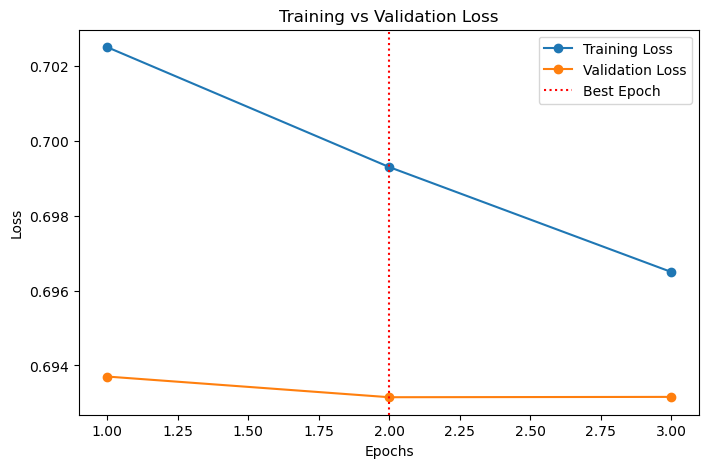

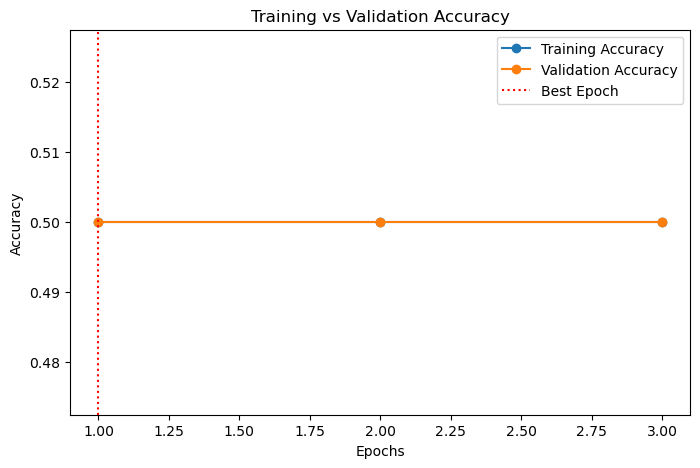

In [10]:
# --- Plot Loss ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
best_epoch = np.argmin(val_loss)
plt.axvline(epochs[best_epoch], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("Training vs Validation Loss.png")
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label="Training Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Validation Accuracy", marker="o")
best_epoch_acc = np.argmax(val_acc)
plt.axvline(epochs[best_epoch_acc], color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("Training vs Validation Accuracy.png")
plt.show()

# Confusion Matrix on Test Set

c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


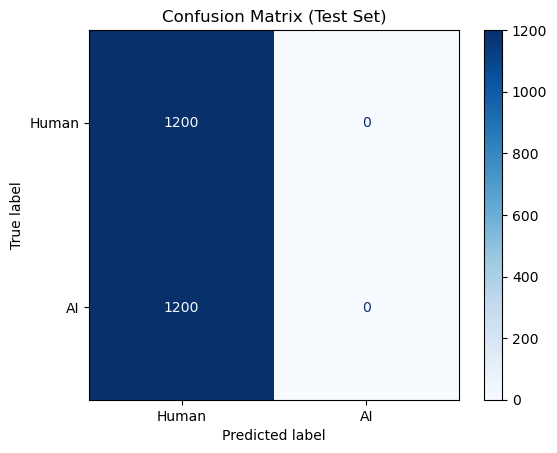

Classification Report (Test Set):

              precision    recall  f1-score   support

       Human     0.5000    1.0000    0.6667      1200
          AI     0.0000    0.0000    0.0000      1200

    accuracy                         0.5000      2400
   macro avg     0.2500    0.5000    0.3333      2400
weighted avg     0.2500    0.5000    0.3333      2400



c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Make predictions on test set ---
preds_output = trainer.predict(test_dataset)

# Sometimes predictions come wrapped like (logits,) — handle both cases
logits = preds_output.predictions
if isinstance(logits, (tuple, list)):
    logits = logits[0]

# Now take argmax across the label dimension
preds = np.argmax(logits, axis=-1)

# --- Confusion Matrix ---
cm = confusion_matrix(test_labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human","AI"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.savefig("confusion_matrix.png")
plt.show()

# --- Classification Report ---
report = classification_report(test_labels, preds, target_names=["Human", "AI"], digits=4)
print("Classification Report (Test Set):\n")
print(report)

In [13]:
# Save the final model and tokenizer
trainer.save_model("./xlm-r_model")  # Saves model + config
tokenizer.save_pretrained("./xlm-r_tokenizer")  # Saves tokenizer files

('./xlm-r_tokenizer\\tokenizer_config.json',
 './xlm-r_tokenizer\\special_tokens_map.json',
 './xlm-r_tokenizer\\sentencepiece.bpe.model',
 './xlm-r_tokenizer\\added_tokens.json',
 './xlm-r_tokenizer\\tokenizer.json')

# About Model

In [14]:
# --- Model info ---
from transformers import AutoConfig

# Print model architecture
print("\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Print model configuration
config = AutoConfig.from_pretrained("xlm-roberta-base")
print("\nModel configuration:")
print(config)


Model architecture:
XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_featur

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Paths where you saved the model + tokenizer
model_path = "./xlm-r_model"
tokenizer_path = "./xlm-r_tokenizer"

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    id2label={0: "Human", 1: "AI"},
    label2id={"Human": 0, "AI": 1}
)

# Create pipeline for inference
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# --- Test a random text ---
test_text = "এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।"
result = classifier(test_text)

print("Input:", test_text)
print("Prediction:", result)


Input: এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।
Prediction: [{'label': 'Human', 'score': 0.5166783332824707}]
